In [6]:
import sys
sys.path.insert(0, '..')

import os
DATA_FILE = "../data/"
RESULT_FILE = "../result/"


## Data and equation solving

In [39]:
# Solving the ODE system for 1mM
from ode_equation.Millard_dicts import ode_parameters_dict, ode_parameter_ranges_dict, variable_standard_deviations_dict
from scipy.integrate import solve_ivp
from ode_equation.deriv_equations_Millard import deriv_Millard

import numpy as np
import matplotlib.pyplot as plt
from numpy import genfromtxt

# Initial conditions used by Millard
GLC_1_0 = 12.89999655
ACE_env_1_0 = 0.9200020244
X_1_0 = 0.06999993881

# Eyeball estimated initial conditions
ACCOA_1_0 = 0.27305
ACP_1_0 = 0.063
ACE_cell_1_0 = 1.035

# Initial conditions vector
y_1_0 = [GLC_1_0, ACE_env_1_0, X_1_0, ACCOA_1_0, ACP_1_0, ACE_cell_1_0] 

res = solve_ivp(fun=deriv_Millard,
                t_span=(0,4.25),
                y0=y_1_0,
                method='LSODA',
                args=(ode_parameters_dict,))

GLC, ACE_env, X, ACCOA, ACP, ACE_cell = res.y

# Load experimental data 
data_1 = genfromtxt(os.path.join(DATA_FILE,'data_1mM.csv'), delimiter=',')

# Export generated data from ODE solving
generated_Millard_data = np.asarray([res.t, GLC, ACE_env, X, ACCOA, ACP, ACE_cell]) 
np.savetxt(os.path.join(DATA_FILE,"generated_Millard_data.csv"), generated_Millard_data, delimiter=",")

#load generated data
ode_data_1 = genfromtxt(os.path.join(DATA_FILE,'generated_Millard_data.csv'), delimiter=',') # in the form [t, GLC, ACE_env, X, ACCOA, ACP, ACE_cell]

## Neural Network Training for initial ACE 1mM

In [32]:

# Training parameters 
import torch
import torch.optim as optim

import torch
import torch.optim as optim

epoch_number = 100000

# Optimizer parameters
optimizer_type = "Adam"
# optimizer_type = optim.Adam
learning_rate = 1e-4
optimizer_hyperparameters = {"lr":learning_rate}



# Scheduler parameters (unused right now)
scheduler_type = optim.lr_scheduler.CyclicLR

scheduler_hyperparameters = {"base_lr":1e-7, 
                             "max_lr":1e-3, 
                             "step_size_up":10000,
                             "scale_mode":"exp_range",
                             "gamma":0.9,
                             "cycle_momentum":False}

# scheduler_hyperparameters = {"base_lr":1e-4, 
                            #  "max_lr":1e-4, 
                            #  "step_size_up":100,
                            #  "scale_mode":"exp_range",
                            #  "gamma":0.999,
                            #  "cycle_momentum":False}

# Loss calculation method
method_list=[None,
         "soft_adapt",
         "prior_losses"]

In [33]:
# Setting variables (known and unknown), parameters, parameters ranges, constants, weights 
import random
from lib.tools import random_ranges, ssr_error

random.seed(42)

observables = ["GLC","ACE_env","X","ACCOA","ACP","ACE_cell"]
variable_data = {v : ode_data_1[i+1] for i,v in enumerate(observables)}
variable_no_data  = {}
# variable_no_data  = {"ACCOA":None,"ACP":None,"ACE_cell":None}

data_t = res.t

residual_weights_list = [[1,1,1,1e-11,1e-12,1e-5],[1,1,1,1e-11,1e-12,1e-5],[1,1,1,1,1,1]]
variable_fit_weights = [1,1,1,1,1,1]

parameter_names = ["v_max_AckA", "v_max_Pta", "Ki_ACE_glycolysis", "Km_ACCOA_TCA_cycle", "Ki_ACE_TCA_cycle", "Y", "Km_ACE_acetate_exchange"]

# Creating the ranges: using the ranges provided by Millard
ranges = [ode_parameter_ranges_dict[key] for key in parameter_names]

constants_dict = ode_parameters_dict

In [34]:
# Create the PINN
from lib.pinn import Pinn
# from deriv_equations_Millard import ODE_residual_dict_Millard

from ode_equation.deriv_equations_Millard import ODE_residual_dict_Millard

torch.manual_seed(40)

pinn_cell_list = [Pinn(ode_residual_dict=ODE_residual_dict_Millard,
                       ranges=ranges,
                       data_t=data_t,
                       variables_data=variable_data,
                       variables_no_data=variable_no_data,
                       parameter_names=parameter_names,
                       optimizer_type=optimizer_type,
                       optimizer_hyperparameters=optimizer_hyperparameters,
                    #    scheduler_type=scheduler_type,
                       scheduler_hyperparameters=scheduler_hyperparameters,
                       residual_weights=residual_weights_list[i],
                       variable_fit_weights=variable_fit_weights,
                       constants_dict=constants_dict,
                       multi_loss_method=method_list[i],
                       ) for i in range(len(method_list))]

In [35]:
# Training
train_list = [list(pinn_cell.train(epoch_number)) for pinn_cell in pinn_cell_list]
r2_store_list, pred_variables_list, losses_list, variable_fit_losses_list, residual_losses_list, all_learned_parameters_list, learning_rates_list = (list(train) for train in zip(*train_list))

GLC_pred_list, ACE_env_pred_list, X_pred_list, ACCOA_pred_list, ACP_pred_list, ACE_cell_pred_list  = (list(train) for train in zip(*pred_variables_list))
learned_parameters_list = [[pinn_cell.output_param_range(v,i).item() for (i,(k,v)) in enumerate(pinn_cell.ode_parameters.items())] for pinn_cell in pinn_cell_list]

Training the neural network: 100%|███████████████████████████████████████████████████████████████████████████| 100000/100000 [12:16<00:00, 135.77it/s]


## Assessment

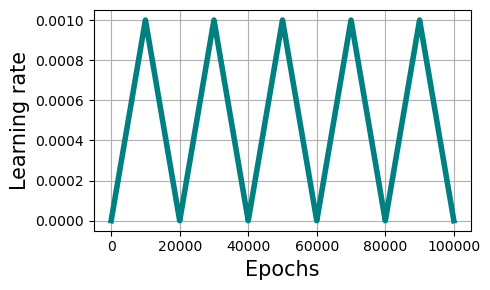

In [36]:
# Print and Plot learning rate
plt.figure(figsize=(5,3))
plt.plot(learning_rates_list[0][0:], color = 'teal',linewidth=4)
plt.grid(True)
plt.xlabel('Epochs',fontsize=15)
plt.ylabel('Learning rate',fontsize=15)

plt.tight_layout()

plt.show()

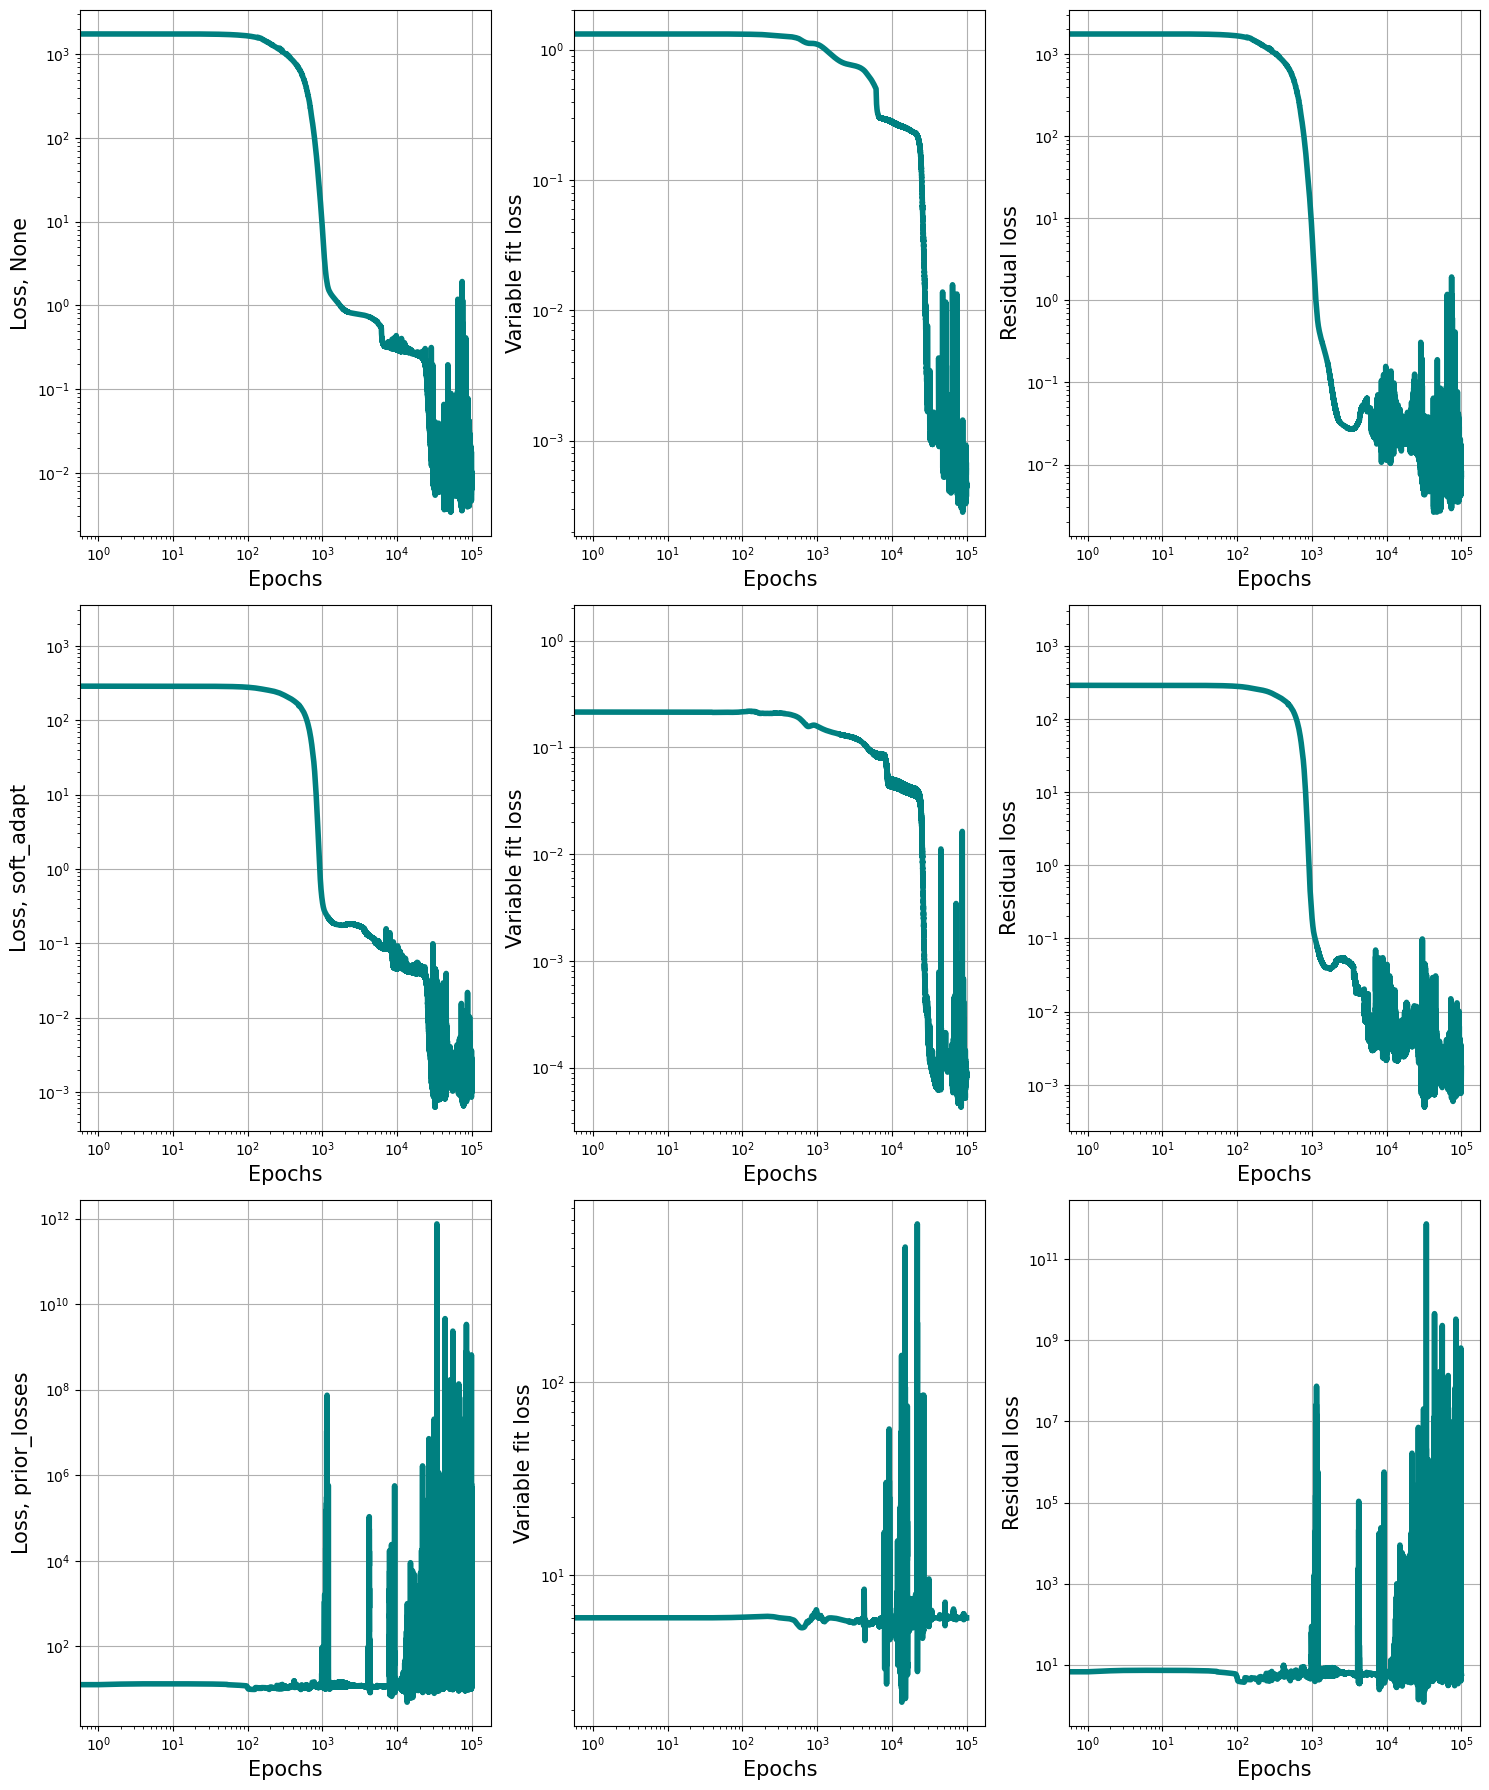

In [37]:
# Plot Losses

fig, axs = plt.subplots(3, 3, figsize=(15, 18))

#1
for i in range(len(method_list)):
    axs[i][0].plot(losses_list[i][0:], color = 'teal',linewidth=4)
    axs[i][0].grid(True)
    axs[i][0].set_xlabel('Epochs',fontsize=15)
    axs[i][0].set_ylabel('Loss, ' + str(method_list[i]),fontsize=15)
    axs[i][0].set_xscale('log')
    axs[i][0].set_yscale('log')

    axs[i][1].plot(variable_fit_losses_list[i][0:], color = 'teal',linewidth=4)
    axs[i][1].grid(True)
    axs[i][1].set_xlabel('Epochs',fontsize=15)
    axs[i][1].set_ylabel('Variable fit loss',fontsize=15)
    axs[i][1].set_xscale('log')
    axs[i][1].set_yscale('log')

    axs[i][2].plot(residual_losses_list[i][0:], color = 'teal',linewidth=4)
    axs[i][2].grid(True)
    axs[i][2].set_xlabel('Epochs',fontsize=15)
    axs[i][2].set_ylabel('Residual loss',fontsize=15)
    axs[i][2].set_xscale('log')
    axs[i][2].set_yscale('log')

plt.tight_layout()
plt.show()

In [40]:
# Integrate the Millard's model equations over the time grid
for i in range(len(method_list)):
    learned = DICT.copy()
    learned = learned | dict(zip(parameter_names, learned_parameters_list[i]))

    net_res = solve_ivp(fun=deriv_Millard,
                    t_span=(0,4.25),
                    y0=y_1_0,
                    method='LSODA',
                    args=(learned,),
                    t_eval=data_t,
                    dense_output=True)

    GLC_learned, ACE_env_learned, X_learned, ACCOA_learned, ACP_learned, ACE_cell_learned = net_res.y
    variable_res = {"GLC":GLC_learned, "ACE_env":ACE_env_learned, "X":X_learned, "ACCOA":ACCOA_learned, "ACP":ACP_learned, "ACE_cell":ACE_cell_learned}
    error = ssr_error(standard_deviations_dict=variable_standard_deviations_dict, observables=observables, variable_data=variable_data, variable_res=variable_res)
    print("Sum of squared residuals error using " + str(method_list[i]) + ": " + str(error))

Sum of squared residuals error using None: 1137.6057273185029
Sum of squared residuals error using soft_adapt: 1330.3787028036104
Sum of squared residuals error using prior_losses: 5212.000961982441
